In [1]:
import openai
import pandas as pd
import numpy as np
import math

In [2]:
!pip3 install openai

DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/avgn-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


# Are informal comments more toxic?

In this notebook we'll use Marianna Apidianaki's method of calculating interpretable dimensions in semantic vector space on the fly using seed pairs. To start, we want to look at the same dimensions: formality and complexity. But we want to look at the sentence level rather than the word level. 

## Step 1: Generating formality seed pairs

We want sevenish pairs of sentences, or really two symmetrical groups of sentences, that can be used to calculate a dimension. 

In [3]:
sentences = """Last week I got into a car accident.
She had some amazing news to share but nobody to share it with.
Sometime you just have to give up and win by cheating.
They desperately needed another drummer since the current one only knew how to play bongos.
The bread dough reminded her of Santa Clause’s belly.
He realized there had been several deaths on this road, but his concern rose when he saw the exact number.
Trash covered the landscape like sprinkles do a birthday cake."""
sentences = sentences.split("\n")
sentences

['Last week I got into a car accident.',
 'She had some amazing news to share but nobody to share it with.',
 'Sometime you just have to give up and win by cheating.',
 'They desperately needed another drummer since the current one only knew how to play bongos.',
 'The bread dough reminded her of Santa Clause’s belly.',
 'He realized there had been several deaths on this road, but his concern rose when he saw the exact number.',
 'Trash covered the landscape like sprinkles do a birthday cake.']

### Step 1: Load and use GPT to generate sentences

In [4]:
from openai import OpenAI
client = OpenAI() # OPENAI_API_KEY environment variable must be set. see quickstart tutorial here: https://platform.openai.com/docs/quickstart?context=python



Try an example completion

In [5]:
sentence = sentences[0]

messages=[
    {"role": "system", "content": "You are a rewording assistant, skilled in transforming a statement to express more or less of a given quality or property."},
    {"role": "user", "content": "Rephrase the following statement to use language that is more complex: \"{}\" .".format(sentence)}
  ]


In [6]:
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=messages
)

print(completion.choices[0].message)

ChatCompletionMessage(content='Last week, I was involved in a motor vehicle collision.', role='assistant', function_call=None, tool_calls=None)


In [7]:
completion.choices[0]

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Last week, I was involved in a motor vehicle collision.', role='assistant', function_call=None, tool_calls=None))

We'll feed this output back to the api 

In [8]:
messages.append({'role': 'system', 'content': completion.choices[0].message.content})
messages.append({"role": "user", "content": "Good. Rephrase the sentence again to use language that is even more complex."})
messages

[{'role': 'system',
  'content': 'You are a rewording assistant, skilled in transforming a statement to express more or less of a given quality or property.'},
 {'role': 'user',
  'content': 'Rephrase the following statement to use language that is more complex: "Last week I got into a car accident." .'},
 {'role': 'system',
  'content': 'Last week, I was involved in a motor vehicle collision.'},
 {'role': 'user',
  'content': 'Good. Rephrase the sentence again to use language that is even more complex.'}]

In [9]:
def complete(messages):
    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=messages,
      seed=42
    )
    return completion.choices[0].message.content

complete(messages)

'During the previous week, I found myself embroiled in an unfortunate incident involving a vehicular collision.'

### prompt templates

In [10]:
# dictionary of the adjectives we use (property adjective and antonym) to create prompts

property_dict = {
    'complexity':   ('complex', 'simple'),
    'emotion':      ('emotional', 'emotionless')
}


We will generate sentences from a series of templates. For each sentence, we want to generate 'more x', 'even more x', as well as 'less x' and 'even less x'. Because the model often produces longer sentences for 'more' prompts, we also prompt for rephrasings using an antonymous adjective. So, for example, we ask for rephrasings that are "more complex" as well as rephrasings that are "less simple". We then use all of these rephrasings to calculate the complexity dimension.

In [11]:
# TODO save 5 responses instead of 1


adj, antonym = property_dict['complexity']

data = []

for sent in sentences:

    for i, x in enumerate([adj, antonym]):
        print(i)
        print(x)
        messages=[
            {"role": "system", "content": "You are a rewording assistant, skilled in transforming a statement to express more or less of a given quality or property."},
        ]

        
        # more
        more_messages = messages + [{"role": "user", "content": "Rephrase the following statement to use language that is more {}: \"{}\" .".format(x,sent)}]
        more = complete(more_messages)
        print(more)
        
        # less
        less_messages = messages + [{"role": "user", "content": "Rephrase the following statement to use language that is less {}: \"{}\" .".format(x,sent)}]
        less = complete(less_messages)
        print(less)
        
        row = {
             'sentence': sent,
             'text1': more,
             'text2': less,
             'more': 1,
             'even_more': 0,
             'less': 1,
             'even_less':  0,
             'property': 'complexity',
             'adjective': x,
             'antonym?': 0 if i == 0 else 1 # the second in the pair is the antonym
        }
        data.append(row)
                
        # even more
        even_more_messages = more_messages + [{"role": "system", "content": more}] + [{"role": "user", "content": "Good. Rephrase the sentence again to use language that is even more {}.".format(x)}]
        even_more = complete(even_more_messages)
        print(even_more)
        
        # even less
        even_less_messages = less_messages + [{"role": "system", "content": less}] + [{"role": "user", "content": "Good. Rephrase the sentence again to use language that is even less {}.".format(x)}]
        even_less = complete(even_less_messages)
        print(even_less)
        
        row = {
             'sentence': sent,
             'text1': even_more,
             'text2': even_less,
             'more': 0,
             'even_more': 1,
             'less': 0,
             'even_less':  1,
             'property': 'complexity',
             'adjective': x,
             'antonym?': 0 if i == 0 else 1 # the second in the pair is the antonym
        }
        data.append(row)

        # TODO even even more


    
df = pd.DataFrame.from_records(data)
df

0
complex
The previous week, I was involved in a vehicular collision.
I had a car accident last week.
During the preceding week, I found myself embroiled in a motor vehicle collision.
I had a crash with my car last week.
1
simple
I had a car crash last week.
Last week I was involved in a collision while operating a motor vehicle.
I had a car accident last week.
During the course of the previous week, I was engaged in a vehicular collision resulting in damage to my automobile.
0
complex
She was in possession of astounding news, yet there was a dearth of individuals with whom she could disseminate it.
She had exciting news to tell, but no one to tell it to.
She found herself in the possession of awe-inspiring tidings that yearned to be shared, however, she was met with the unfortunate circumstance of not having anyone in her proximity with whom she could partake in the act of disseminating the aforementioned news.
She had great news, but no one to tell it to.
1
simple
She had some great 

,sentence,text1,text2,more,even_more,less,even_less,property,adjective,antonym?
0,Last week I got into a car accident.,"The previous week, I was involved in a vehicul...",I had a car accident last week.,1,0,1,0,complexity,complex,0
1,Last week I got into a car accident.,"During the preceding week, I found myself embr...",I had a crash with my car last week.,0,1,0,1,complexity,complex,0
2,Last week I got into a car accident.,I had a car crash last week.,Last week I was involved in a collision while ...,1,0,1,0,complexity,simple,1
3,Last week I got into a car accident.,I had a car accident last week.,"During the course of the previous week, I was ...",0,1,0,1,complexity,simple,1
4,She had some amazing news to share but nobody ...,"She was in possession of astounding news, yet ...","She had exciting news to tell, but no one to t...",1,0,1,0,complexity,complex,0
5,She had some amazing news to share but nobody ...,She found herself in the possession of awe-ins...,"She had great news, but no one to tell it to.",0,1,0,1,complexity,complex,0
6,She had some amazing news to share but nobody ...,She had some great news to tell but no one to ...,"She possessed extraordinary tidings to impart,...",1,0,1,0,complexity,simple,1
7,She had some amazing news to share but nobody ...,"She had really good news, but no one to tell i...",She harbored a multitude of astounding revelat...,0,1,0,1,complexity,simple,1
8,Sometime you just have to give up and win by c...,"Occasionally, one must relinquish and emerge v...",Sometimes you have no choice but to resort to ...,1,0,1,0,complexity,complex,0
9,Sometime you just have to give up and win by c...,"On certain occasions, it becomes necessary to ...","Sometimes, cheating is the only way to win.",0,1,0,1,complexity,complex,0


Save so we don't have to query the api every time

In [12]:
df.to_csv('make_it_more_complexity_pilot_seed_sentences.csv')

## Step 2: Calculating the formality dimension



In [13]:
df = pd.read_csv('make_it_more_complexity_pilot_seed_sentences.csv')

Now that we have our seed sentences for the complexity dimension, we need to get the vector differences for the seed pairs.

We generated 8 sentences for each original seed sentence, meaning we have four seed pairs.

The formulas for the four seed pairs are as follows:

- ( adjective + more ) - (adjective + less)
- ( adjective + even more ) - (adjective + even less)
- ( antonym + less ) - (antonym + more )
- ( antonym + even less ) - (antonym + even more )

First we get an embedding for both complementary sentences in each row (text1 and text2). Then, for each seed sentence we calculate these four formulae to get the vector differences. And then we average those together. 

In [14]:
df.head(5)

,Unnamed: 0,sentence,text1,text2,more,even_more,less,even_less,property,adjective,antonym?
0,0,Last week I got into a car accident.,"The previous week, I was involved in a vehicul...",I had a car accident last week.,1,0,1,0,complexity,complex,0
1,1,Last week I got into a car accident.,"During the preceding week, I found myself embr...",I had a crash with my car last week.,0,1,0,1,complexity,complex,0
2,2,Last week I got into a car accident.,I had a car crash last week.,Last week I was involved in a collision while ...,1,0,1,0,complexity,simple,1
3,3,Last week I got into a car accident.,I had a car accident last week.,"During the course of the previous week, I was ...",0,1,0,1,complexity,simple,1
4,4,She had some amazing news to share but nobody ...,"She was in possession of astounding news, yet ...","She had exciting news to tell, but no one to t...",1,0,1,0,complexity,complex,0


--NOPE__So now that we have our seed sentences for the complexity dimension, we need to split them into negative and positive sentences. The generated sentences should be divided as follows.

Positive
- adjective + more
- adjective + even more
- antonym + less
- antonym + even less

Negative
- adjective + less
- adjective + even less
- antonym + more
- antonym + even more

After we split them into positive and negative examples, we embed them using SBERT--

Obviously we run into the problem where vectors are word level and we want sentence-level representations. The absolute simplest thing I can think of to do here is to use SentenceBERT, which we will download from huggingface.

After initializing the model, we generate vector representations for each sentence in the informal list and for each corresponding sentence in the formal list. We subtract the vectors from one another and then take the average, leaving us with a vector that represents the formality dimension. We can rate any sentence vector(s) on the formality dimension by giving them (as a list) to the function predict_scalarproj along with the dimension itself. 

In [16]:
# load sbert
!pip install -U sentence-transformers

DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/avgn-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 2.0 MB/s eta 0:00:00 MB/s eta 0:00:01


In [ ]:
text1 = dfp

In [18]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

text1 = df['text1'].to_list()
text2 = df['text2'].to_list()

#Sentences are encoded by calling model.encode()
embeddings1 = model.encode(text1)
embeddings2 = model.encode(text2)


#df = df.assign(embedding1=embeddings1.tolist())
#df = df.assign(embedding2=embeddings2.tolist())


df.head(5)

# #Print the embeddings
# for sentence, embedding in zip(positive[:5], pos_embeddings[:5]):
#     print("Sentence:", sentence)
#     print("Embedding:", embedding[:100])
#     print("")

,Unnamed: 0,sentence,text1,text2,more,even_more,less,even_less,property,adjective,antonym?,embedding1,embedding2
0,0,Last week I got into a car accident.,"The previous week, I was involved in a vehicul...",I had a car accident last week.,1,0,1,0,complexity,complex,0,"[0.05463976413011551, 0.04207246005535126, 0.0...","[-0.016751712188124657, 0.004364476073533297, ..."
1,1,Last week I got into a car accident.,"During the preceding week, I found myself embr...",I had a crash with my car last week.,0,1,0,1,complexity,complex,0,"[0.016205454245209694, 0.018613578751683235, 0...","[0.024704132229089737, 0.01558883860707283, 0...."
2,2,Last week I got into a car accident.,I had a car crash last week.,Last week I was involved in a collision while ...,1,0,1,0,complexity,simple,1,"[0.014592831023037434, -0.003254925599321723, ...","[0.05353369563817978, 0.02159007079899311, 0.0..."
3,3,Last week I got into a car accident.,I had a car accident last week.,"During the course of the previous week, I was ...",0,1,0,1,complexity,simple,1,"[-0.016751712188124657, 0.004364476073533297, ...","[0.05612611025571823, 0.05228176712989807, 0.0..."
4,4,She had some amazing news to share but nobody ...,"She was in possession of astounding news, yet ...","She had exciting news to tell, but no one to t...",1,0,1,0,complexity,complex,0,"[0.011493628844618797, 0.059226855635643005, 0...","[0.038831476122140884, 0.027946915477514267, 0..."


In [22]:
difference_vecs = (embeddings1-embeddings2)

In [26]:
dimvec = np.mean(difference_vecs, axis = 0)
dimvec

array([-6.8965023e-03, -5.6659459e-04,  1.5460422e-03, -8.7708829e-04,
        7.2396388e-03,  4.1472060e-03,  1.9682597e-03, -4.2196838e-03,
        3.9485836e-04, -7.8492932e-04,  4.1114953e-03, -1.7584482e-03,
        1.2596576e-03, -7.2792852e-03,  4.4339136e-04, -2.3448355e-03,
       -1.8821467e-03,  7.8109666e-03, -4.5756958e-03, -3.1327221e-03,
       -1.3105258e-02, -5.0993678e-03,  1.2832416e-03, -4.6180263e-03,
        2.2514041e-03, -8.2333032e-03,  3.2548173e-03, -1.0937602e-03,
       -2.3927470e-03, -1.5277287e-03,  5.7566953e-03, -9.7412482e-04,
        5.4619429e-03,  9.4161034e-05,  3.3427014e-03,  2.3252766e-03,
        1.5675417e-03, -5.8196858e-04, -6.6797310e-03,  5.0237128e-03,
        2.2438217e-03, -2.0526124e-03,  3.0405505e-03, -1.0291407e-04,
        6.5335783e-04, -5.9105568e-03,  1.4018369e-03,  5.1945611e-03,
        5.2535348e-03,  1.4014143e-03, -1.7069828e-03, -1.4668209e-03,
       -2.7253535e-03,  9.9160439e-05, -2.7645428e-03,  9.8385522e-03,
      

In [27]:
#### from marianna + katrin
# seed-based method
# averaging over seed pair vectors
# def dimension_seedbased(seeds_pos, seeds_neg, space, paired = False):
#     diffvectors = [ ]
    
#     for negword, posword in _make_seedpairs(seeds_pos, seeds_neg, paired = paired):
#         diffvectors.append(space[posword] - space[negword])

#     # average
#     dimvec = np.mean(diffvectors, axis = 0)
#     return dimvec


In [28]:
def dimension_seedbased():
    return dimvec

In [29]:
complexity_dimension = dimension_seedbased()

In [30]:
# vector scalar projection (from marianna + katrin)
def predict_scalarproj(veclist, dimension):
    dir_veclen = math.sqrt(np.dot(dimension, dimension))
    return [np.dot(v, dimension) / dir_veclen for v in veclist]

# Step 3: validating the formality dimension

does it behave the same way as a standard classifier?


We load a regular classifier

We run this prediction method and the formality classifier on the formality dataset. 

We compare. Is the dimension-based method that much worse?

We load a formality dataset - perhaps the word-based one that Marianna uses.

We order the entries by their complexity rating and look at where they fall on our complexity axis.

## Step 4: Rating Toxicity Datasets for formality

We'll start with the 1000-length parallel dataset from the text detoxification paper. 

We load it in

We SBERTize the sentences

We pass them to the prediction method. 

We observe: do toxic and nontoxic comments differ wrt formality?

In [31]:
!pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/avgn-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [33]:
from datasets import load_dataset

dataset = load_dataset("civil_comments")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /Users/gabriellachronis/.cache/huggingface/datasets/parquet/civil_comments-e92c9358c47debf9/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [34]:
dataset["train"][0]

{'text': "This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",
 'toxicity': 0.0,
 'severe_toxicity': 0.0,
 'obscene': 0.0,
 'threat': 0.0,
 'insult': 0.0,
 'identity_attack': 0.0,
 'sexual_explicit': 0.0}

In [35]:
dataset["train"][:10]['text']

["This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",
 "Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",
 'This is such an urgent design problem; kudos to you for taking it on. Very impressive!',
 "Is this something I'll be able to install on my site? When will you be releasing it?",
 'haha you guys are a bunch of losers.',
 'ur a sh*tty comment.',
 'hahahahahahahahhha suck it.',
 'FFFFUUUUUUUUUUUUUUU',
 'The ranchers seem motivated by mostly by greed; no one should have the right to allow their animals destroy public land.',
 "It was a great show. Not a combo I'd of expected to be good together but it was."]

In [36]:
###################################
#########
# predicting ratings on a dimension

# ...
# when we only have the dimension:
# vector scalar projection
def predict_scalarproj(veclist, dimension):
    dir_veclen = math.sqrt(np.dot(dimension, dimension))
    return [np.dot(v, dimension) / dir_veclen for v in veclist]

SBERtize the Comments

In [51]:
sentence_embs = [model.encode(row) for row in dataset["train"][:1000]['text']]


Calculate complexity 

In [59]:
complexities = predict_scalarproj(sentence_embs, dimvec)

# for i, emb in enumerate(sentence_embs):
#     dataset["train"][i]['complexity_computed'] = sentence_embs[i]
#     complexities.append( sentence_embs[i] )

#dataset["train"][:5]
complexities[:5]

[0.1866481524433775,
 0.024915218121990622,
 0.07795014414126437,
 0.05866463558626613,
 0.021552864707469758]

Retrieve gold toxicity score

In [66]:
toxicity_scores = dataset["train"][:1000]['toxicity']

In [67]:
dataset["train"][:10]['text']

["This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",
 "Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",
 'This is such an urgent design problem; kudos to you for taking it on. Very impressive!',
 "Is this something I'll be able to install on my site? When will you be releasing it?",
 'haha you guys are a bunch of losers.',
 'ur a sh*tty comment.',
 'hahahahahahahahhha suck it.',
 'FFFFUUUUUUUUUUUUUUU',
 'The ranchers seem motivated by mostly by greed; no one should have the right to allow their animals destroy public land.',
 "It was a great show. Not a combo I'd of expected to be good together but it was."]

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

Text(0, 0.5, 'toxicity')

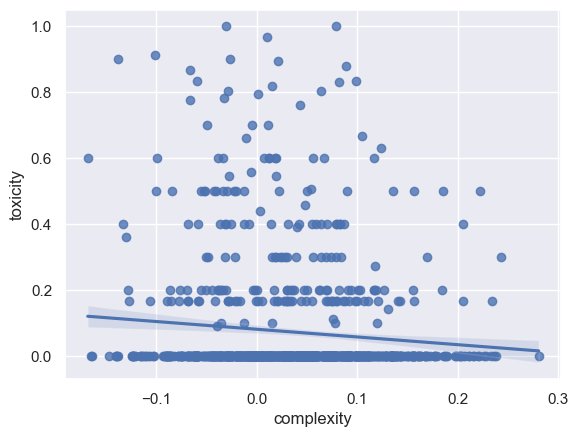

In [71]:
sns.regplot(x=complexities, y=toxicity_scores)
plt.xlabel("complexity")
plt.ylabel("toxicity")

In [64]:
import numpy as np
import scipy.stats

scipy.stats.pearsonr(complexities, scores)    # Pearson's r

PearsonRResult(statistic=-0.09896626191154356, pvalue=0.0017281219504836492)

Complexity and toxicity are negatively correlated, as predicted. As complexity increases, toxicity decreases. 